<a href="https://colab.research.google.com/github/umiSirya/Weather_Prediction_capstone_project/blob/main/LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.dates as mdates




In [2]:
df=pd.read_csv('/content/result.csv')
df.head()

,Y,X,uv_index_hourly_average,url,dataset,instance_datetime,platform_id,platform_name,country,gaw_id,instrument_name,instrument_model,instrument_number,uv_index_qa,instance_hour,platform_type,data_payload_id,latest_observation,uv_index_daily_max,agency
0,45.74,7.36,0.177875,http://woudc.org/archive/Archive-NewFormat/Spe...,Spectral,2017/10/31 00:00:00,479,Aosta,ITA,AST,brewer,MKIV,66,P,9,STN,2884025,0,1.19455,ARPA-VDA
1,45.74,7.36,1.194550,http://woudc.org/archive/Archive-NewFormat/Spe...,Spectral,2017/10/31 00:00:00,479,Aosta,ITA,AST,brewer,MKIV,66,P,13,STN,2884039,0,1.19455,ARPA-VDA
2,45.74,7.36,0.188125,http://woudc.org/archive/Archive-NewFormat/Spe...,Spectral,2017/10/31 00:00:00,479,Aosta,ITA,AST,brewer,MKIV,66,P,16,STN,2884049,0,1.19455,ARPA-VDA
3,45.74,7.36,0.989250,http://woudc.org/archive/Archive-NewFormat/Spe...,Spectral,2017/10/31 00:00:00,479,Aosta,ITA,AST,brewer,MKIV,66,P,11,STN,2884032,0,1.19455,ARPA-VDA
4,45.74,7.36,0.544150,http://woudc.org/archive/Archive-NewFormat/Spe...,Spectral,2017/10/30 00:00:00,479,Aosta,ITA,AST,brewer,MKIV,66,P,15,STN,2880762,0,1.49725,ARPA-VDA


# **Exploratory Data Analysis**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6940 entries, 0 to 6939
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Y                        6940 non-null   float64
 1   X                        6940 non-null   float64
 2   uv_index_hourly_average  6940 non-null   float64
 3   url                      6940 non-null   object 
 4   dataset                  6940 non-null   object 
 5   instance_datetime        6940 non-null   object 
 6   platform_id              6940 non-null   int64  
 7   platform_name            6940 non-null   object 
 8   country                  6940 non-null   object 
 9   gaw_id                   6940 non-null   object 
 10  instrument_name          6940 non-null   object 
 11  instrument_model         6940 non-null   object 
 12  instrument_number        6940 non-null   int64  
 13  uv_index_qa              6940 non-null   object 
 14  instance_hour           

In [4]:
# changing dtype of instance_datetime to datetime
df['instance_datetime'] = pd.to_datetime(df['instance_datetime'])

In [5]:
# extracting the date only from instance_datetime
df['instance_date'] = df['instance_datetime'].dt.date

In [6]:
df = df[['instance_datetime', 'uv_index_daily_max']]

In [7]:
# Set datetime as index
df.set_index('instance_datetime', inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6940 entries, 2017-10-31 to 2009-12-31
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   uv_index_daily_max  6940 non-null   float64
dtypes: float64(1)
memory usage: 108.4 KB


In [9]:
df

,uv_index_daily_max
instance_datetime,
2017-10-31,1.194550
2017-10-31,1.194550
2017-10-31,1.194550
2017-10-31,1.194550
2017-10-30,1.497250
...,...
2009-12-31,0.427563
2009-12-31,0.427563
2009-12-31,0.427563


In [10]:
#checking for null values
df.isnull().sum()

,0
uv_index_daily_max,0


<ipython-input-11-597bd890e5d9>:23: UserWarning: Glyph 127774 (\N{SUN WITH FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127774 (\N{SUN WITH FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


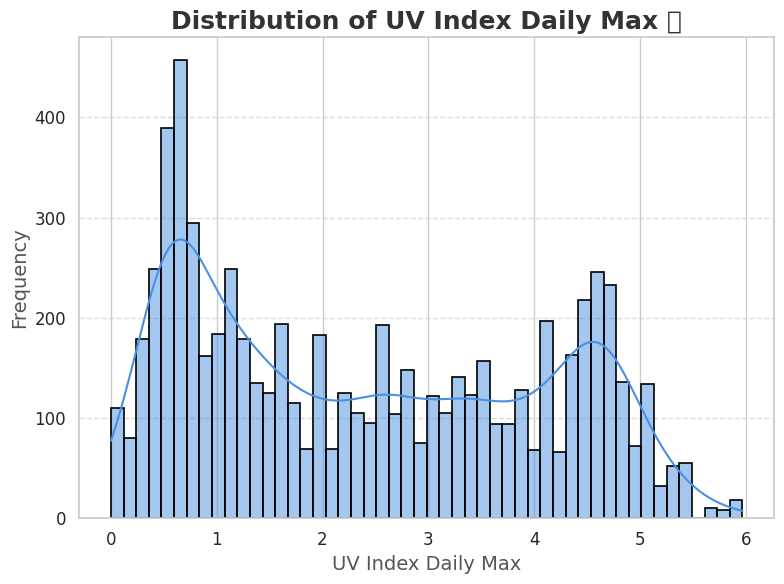

In [11]:
#Frequency Distribution of UV Index daily max

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.histplot(
    data=df,
    x='uv_index_daily_max',
    bins=50,
    kde=True,
    color="#4A90E2",
    edgecolor="black",
    linewidth=1.2
)


plt.title('Distribution of UV Index Daily Max 🌞', fontsize=18, fontweight='bold', color="#333333")
plt.xlabel('UV Index Daily Max', fontsize=14, color="#555555")
plt.ylabel('Frequency', fontsize=14, color="#555555")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# **Data Pre-Processing**

In [12]:
# Train-Test Split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Min-Max Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values)
test_scaled = scaler.transform(test.values)

# Sequence creation
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

# Set sequence length (e.g., 30 days)
seq_length = 30

# Create sequences for training and testing
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape data for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define LSTM Model

In [13]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50),
    Dense(1)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Compile and Train Model

In [14]:
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - loss: 0.0303 - val_loss: 0.0027
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0110 - val_loss: 0.0021
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 0.0085 - val_loss: 0.0015
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0080 - val_loss: 0.0017
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0078 - val_loss: 0.0013
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0075 - val_loss: 0.0015
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 0.0065 - val_loss: 0.0018
Epoch 8/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.0063 - val_loss: 0.0017
Epoch 9/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 0.0067 - val_loss: 0.0015
Epoch 10/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0065 - val_loss: 0.0011
Epoch 11/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - loss: 0.0057 - val_loss: 0.0018
Epoch 12/50
173/173 ━━━━━━━━━━━━━━

In [15]:
# Make The Predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Inverse scale predictions back to original values
train_preds = scaler.inverse_transform(train_preds)
test_preds = scaler.inverse_transform(test_preds)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


# Model Evaluation

In [16]:
mae = mean_absolute_error(y_test_inv, test_preds)
mse = mean_squared_error(y_test_inv, test_preds)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 0.13
Mean Squared Error (MSE): 0.05
Root Mean Squared Error (RMSE): 0.22


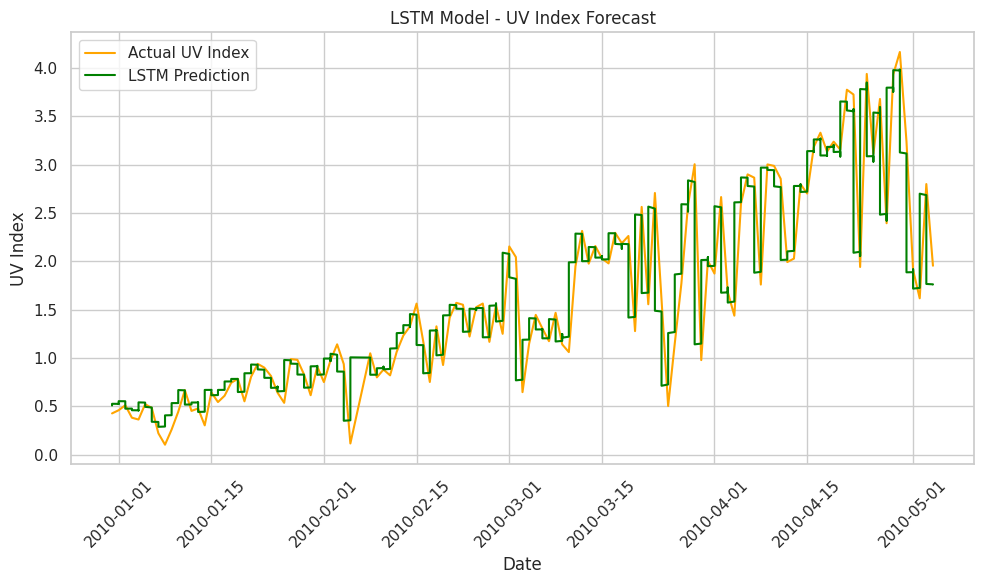

In [17]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size + seq_length:], y_test_inv, color='orange', label='Actual UV Index')
plt.plot(df.index[train_size + seq_length:], test_preds, color='green', label='LSTM Prediction')
plt.title('LSTM Model - UV Index Forecast')
plt.xlabel('Date')
plt.ylabel('UV Index')

# Format date ticks
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
